## 章節 4：更多的估計

### 4.3 被淹沒的先驗分佈

一開始我們用均勻分佈當作先驗分佈，但未必是個好選擇。

我可以相信如果硬幣是不公平的，x 可能會偏離 50%，但不太可能比利時的歐元硬幣是不公平到 x=10% 或 x=90%。

所以更可能選擇一個先驗分佈，有較高的機率當 x 接近 50%，較小的低率出現在極端值。

參考以下個程式碼，我用一個三角形的先驗分佈來代替均勻分佈。

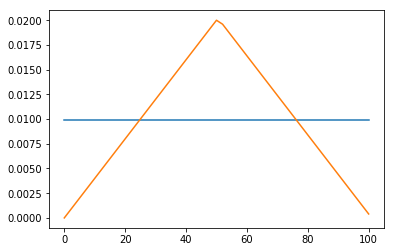

In [33]:
from thinkbayes import Suite, Percentile
import matplotlib.pyplot as plt

class Euro_Uniform(Suite):
    
    def Likelihood(self, data, hypo):
        if data == 'H':
            return hypo/100.0
    
        return 1-hypo/100.0
    
class Euro_Triangular(Euro_Uniform):
    
    def __init__(self, hypos):
        super().__init__()
        size = len(hypos)
        half = size//2+1
        
        # 三角形先驗分佈
        for i in range(half):
            self.Set(hypos[i], i)
        
        for i in range(half+1, size):
            self.Set(hypos[i], size-i)

        self.Normalize()

def plot_suite(suite):
    x, y = zip(*sorted(suite.Items()))
    plt.plot(x, y)
        

hypos = range(101)
suite1 = Euro_Uniform(hypos)
suite2 = Euro_Triangular(hypos)

plot_suite(suite1)
plot_suite(suite2)
plt.show()

上圖顯示

- 藍色線條為均勻先驗分佈
- 橘色線條為三角形先驗分佈

接下來觀察看到資料後的後驗分佈

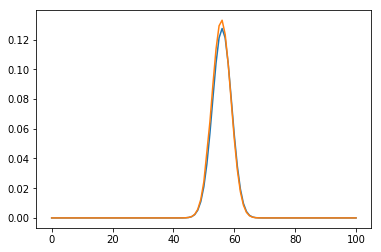

藍色後驗分佈平均值： 55.952380952380956
橘色後驗分佈平均值： 55.95450986075134


In [34]:
def update_distribution(suite, dataset):
    for data in dataset:
        suite.Update(data)


head, tail = 140, 110 # 依據問題出現 140 次正面、110次反面
dataset = 'H' * head + 'T' * tail # 觀察到的資料，不考慮順序

update_distribution(suite1, dataset)
update_distribution(suite2, dataset)
plot_suite(suite1)
plot_suite(suite2)
plt.show()

print("藍色後驗分佈平均值：", suite1.Mean())
print("橘色後驗分佈平均值：", suite2.Mean())

觀察上圖發現不同的先驗分佈，在看到數據後出現**相似的**後驗分佈。

上述便是一個被淹沒的先驗分佈的例子（swamping the priors）：有足夠的資料下，即使不同的先驗分佈，最後會傾向於收斂到相同的後驗分佈(**不必然會發生**)。

接下來想要了解每次看到資料收斂的情況，所以需要一個相似度或是距離的函數。這邊用非對稱的距離 JS-Divergence (對稱距離)來計算目前的後驗分佈與最終的後驗分佈的距離。並且將每次的距離作圖。分別對兩種不同的先驗分佈，來看看誰收斂的比較快。

Euro_Uniform 最後距離為： -0.0
Euro_Triangular 最後距離為： -0.0


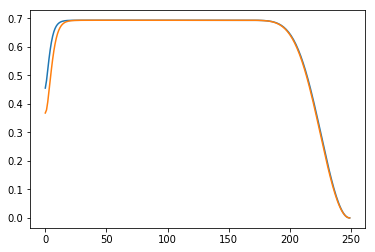

In [43]:
import numpy as np
from thinkbayes import Pmf

def kl_divergence(pmf1, pmf2):
    distance = 0
    for x, prob in pmf1.Items():
        if prob != 0 and pmf2.Prob(x) != 0:
            distance += prob*np.log(pmf2.Prob(x)/prob)

    return -distance

def js_divergence(pmf1, pmf2):
    m = Pmf()
    for v, prob in pmf1.Items():
        m.Set(v, 0.5*(prob+pmf2.Prob(v)))
        
    return 0.5*kl_divergence(pmf1, m)+0.5*kl_divergence(pmf2, m)


def update_distribution_with_rate(suite, answer, dataset):
    dist_list = []
    for data in dataset:
        suite.Update(data)
        dist_list.append(js_divergence(answer, suite))
        
    plt.plot(range(len(dist_list)), dist_list)
    print(suite.__class__.__name__, "最後距離為：", dist_list[-1])

    
def do_exp(shuffle=False):
    hypos = range(101)
    uniform = Euro_Uniform(hypos)
    triangle = Euro_Triangular(hypos)
    head, tail = 140, 110 # 依據問題出現 140 次正面、110次反面
    dataset = list('H' * head + 'T' * tail) # 觀察到的資料，不考慮順序

    if shuffle:
        np.random.shuffle(dataset)

    update_distribution_with_rate(uniform, suite1, dataset)
    update_distribution_with_rate(triangle, suite2, dataset)
    plt.show()
    

do_exp()

可以發現上圖橘色的線條是三角形的先驗分佈，藍色是均勻先驗分佈。發現橘色與目標的後驗分佈距離比較接近，表示此先驗還是比較接近資料的情況。

那資料的順序影響也很大，以下將資料集 140 正面以及 110 反面的順序打亂，來觀察收斂的情況。

Euro_Uniform 最後距離為： -4.4037007638620924e-17
Euro_Triangular 最後距離為： -4.974599138956695e-17


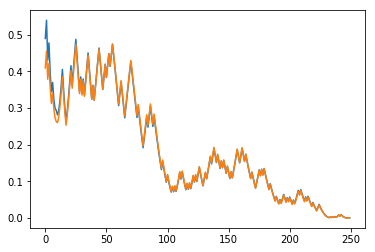

Euro_Uniform 最後距離為： -2.2179037242695622e-17
Euro_Triangular 最後距離為： -1.2218944697522512e-17


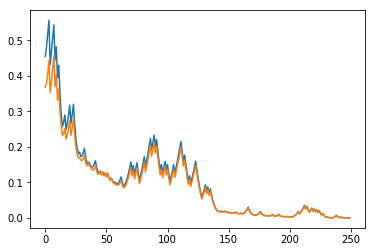

Euro_Uniform 最後距離為： -6.286034440110672e-18
Euro_Triangular 最後距離為： -2.5085917637056133e-17


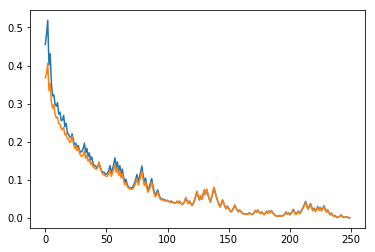

Euro_Uniform 最後距離為： -1.1662394238218423e-17
Euro_Triangular 最後距離為： -2.7325393078057386e-17


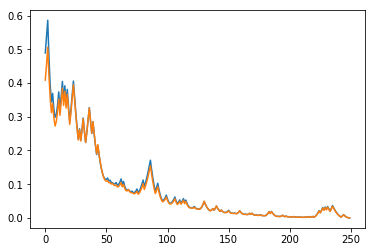

Euro_Uniform 最後距離為： -1.814965412758808e-17
Euro_Triangular 最後距離為： 2.033088317313844e-17


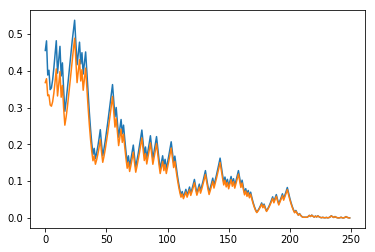

In [44]:
for i in range(5):
    do_exp(shuffle=True)

上方做了五次打亂資料集的實驗，可以發現

1. 最後的距離都收斂到與原資料順序的結果一樣（距離趨近於 0）
2. 沒有出現像原資料集出現距離接近 0.7 的情況
3. 前10個資料三角形先驗分佈的都比均勻分佈的距離來的小
4. 兩者的變化趨勢都接近
5. 資料的順序會影響收斂的過程